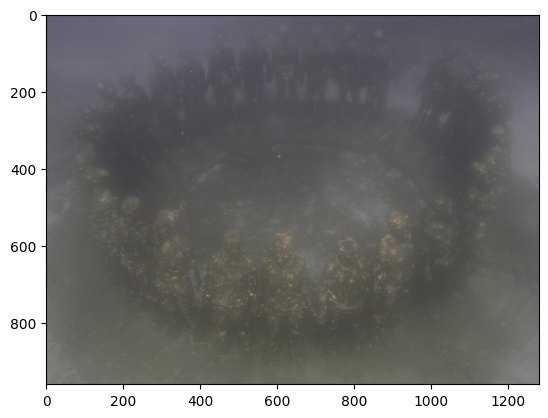

Done


In [30]:
#Load libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
    
def read_image(img_path):
    return cv2.imread(img_path)

def write_image(img_path, img):
    cv2.imwrite(img_path, img)

def normalize(pixel):
    return np.float32(pixel) / 255

def unnormalize(pixel):
    return np.uint8(pixel * 255)

def convert(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# def gray_world(img):
#     dim = np.shape(img)[2]
#     img = np.array(img, dtype='uint8')
#     out = np.zeros(np.shape(img))
#     avg = np.mean(np.mean(img))
#     # 想较原始gray_world有改动
#     for j in range(0, dim):
#         m = np.sum(np.sum(img[:, :, j], axis=0), axis=0)
#         n = np.size(img[:, :, j])
#         scale = n/m
#         g_weight = (avg*scale)
#         out[:, :, j] = img[:, :, j]*g_weight
#     out = np.array(out, dtype='uint8')
#     return out
    
def gray_world(img):
    # Convert image to float32 for precision during calculations
    img_float = np.float32(img)

    # Calculate the average of each channel
    avg_b = np.mean(img_float[:, :, 0])  # Blue channel average
    avg_g = np.mean(img_float[:, :, 1])  # Green channel average
    avg_r = np.mean(img_float[:, :, 2])  # Red channel average

    # Calculate the overall average (mean of the three channels)
    avg_all = (avg_b + avg_g + avg_r) / 3.0

    # Calculate scale factors for each channel
    scale_b = avg_all / avg_b
    scale_g = avg_all / avg_g
    scale_r = avg_all / avg_r

    # Apply the scaling factors to each channel
    img_float[:, :, 0] *= scale_b  # Scale Blue channel
    img_float[:, :, 1] *= scale_g  # Scale Green channel
    img_float[:, :, 2] *= scale_r  # Scale Red channel

    # Clip values to stay within valid range (0 to 255)
    img_float = np.clip(img_float, 0, 255)

    # Convert the image back to uint8
    img_corrected = np.uint8(img_float)

    return img_corrected

# def white_balanced_image(img):
#     img = np.double(img)
#     R = img[:, :, 2]
#     G = img[:, :, 1]
#     B = img[:, :, 0]
#     # 三颜色通道均值，对应 I¯r I¯g I¯b
#     Irm = np.mean(R, axis=0)
#     Irm = np.mean(Irm)/256.0
#     Igm = np.mean(G, axis=0)
#     Igm = np.mean(Igm)/256.0
#     Ibm = np.mean(B, axis=0)
#     Ibm = np.mean(Ibm)/256.0
#     a = 1
#     Irc = R + a * (Igm-Irm)*(1-Irm)*G  # 补偿红色通道
#     Irc = np.array(Irc.reshape(G.shape), np.uint8)
#     Ibc = B + a * (Igm-Ibm)*(1-Ibm)*G  # 补偿蓝色通道
#     Ibc = np.array(Ibc.reshape(G.shape), np.uint8)

#     G = np.array(G, np.uint8)
#     img = cv2.merge([Ibc, G, Irc])
#     return img
    
def white_balanced_image(img, alpha=1, compensate_blue_channel=False):
    """
    Apply white balancing to red channel of BGR underwater images
    
    Args:
        img (np.array): the image to apply white balancing to
        alpha (int) (optional): The weight to apply to color correction (default = 1)
        compensate_blue_channel (bool) (optional): Whether to also apply blue channel correction (need for cases of turbid waters, plankton) (default = False)
    """
    if len(img.shape) < 3:
        raise ValueError("Color image expected, received grayscale image")
    #img = img.copy()
    mean_red = np.mean(img[:, :, 2])
    mean_green = np.mean(img[:, :, 1])
    mean_blue = np.mean(img[:, :, 0]) if compensate_blue_channel else None
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j][2] = unnormalize(normalize(img[i][j][2]) + alpha * (normalize(mean_green) - normalize(mean_red)) * (1 - normalize(img[i][j][2])) * normalize(img[i][j][1]))
            if compensate_blue_channel:
                img[i][j][0] = unnormalize(normalize(img[i][j][0]) + alpha * (normalize(mean_green) - normalize(mean_blue)) * (1 - normalize(img[i][j][0])) * normalize(img[i][j][1]))
    #cv2.imwrite("image_without_grayworld.jpg", img)
    #img = gray_world(img)#wb.balanceWhite(img)
    return img

def normalized_unsharp_masking(img, kernel_size=5):
    b, g, r = cv2.split(img)
    sharpened_channels = []
    for channel in [b, g, r]:
        blurred_channel = cv2.GaussianBlur(channel, (kernel_size, kernel_size), 0)
        sharpened_channel = channel - blurred_channel
        contrast_stretched_channel = cv2.normalize(sharpened_channel, None, 0, 255, cv2.NORM_MINMAX)
        sharpened_channels.append(contrast_stretched_channel)#cv2.addWeighted(channel, 1 + weight, sharpened_img, weight, 0))
    mask = cv2.merge(sharpened_channels)
    return np.uint8((img + mask) / 2)

def gamma_correction(img, gamma_factor=1.5):
    return np.uint8((img/255)**gamma_factor * 255)

def laplacian_contrast_weight(img):
    return cv2.convertScaleAbs(cv2.Laplacian(img, cv2.CV_64F))

def saliency_weight(img):
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    
    # Compute the mean pixel vector (I_mu)
    mean_pixel = lab_image.mean(axis=(0, 1), keepdims=True)  # Broadcast to full image size
    
    # Apply Gaussian blur to the original image (I_ωhc)
    blurred_image = cv2.GaussianBlur(lab_image, (5, 5), 0)
    
    # Compute the L2 norm (Euclidean distance) between I_mu and I_ωhc
    saliency_weight = np.linalg.norm(mean_pixel - blurred_image, axis=2)  # Across the Lab channels
    return saliency_weight

def saturation_weight(grayscale_img, color_img):
    return np.linalg.norm(color_img - grayscale_img[..., np.newaxis], axis=2) / np.sqrt(3)
    # return np.sqrt((color_img[:,:,0] - grayscale_img)**2 + (color_img[:,:,1] - grayscale_img)**2 + (color_img[:,:,2] - grayscale_img)**2) / np.sqrt(3)

def combine_weights(img1mask1, img1mask2, img1mask3, img2mask1, img2mask2, img2mask3):
    img1_weight = img1mask1 + img1mask2 + img1mask3
    img2_weight = img2mask1 + img2mask2 + img2mask3  
    return img1_weight/(img1_weight + img2_weight), img2_weight/(img1_weight + img2_weight)

def gaussian_pyramid(image, levels):
    """
    Generate a Gaussian pyramid from normalised_weight
    """
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, levels):
    """
    Generate a Laplacian pyramid for the given image.
    """
    gaussian_pyr = gaussian_pyramid(image, levels)
    laplacian_pyr = []

    for i in range(levels):
        next_gaussian = cv2.pyrUp(gaussian_pyr[i + 1], dstsize=(gaussian_pyr[i].shape[1], gaussian_pyr[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyr[i], next_gaussian)
        laplacian_pyr.append(laplacian)

    laplacian_pyr.append(gaussian_pyr[-1])  # Add the smallest Gaussian at the top of the pyramid
    return laplacian_pyr

def reconstruct_from_laplacian(laplacian_pyr):
    """
    Reconstruct the image from its Laplacian pyramid.
    """
    reconstructed_image = laplacian_pyr[-1]

    for i in range(len(laplacian_pyr) - 2, -1, -1):
        reconstructed_image = cv2.pyrUp(reconstructed_image, dstsize=(laplacian_pyr[i].shape[1], laplacian_pyr[i].shape[0]))
        reconstructed_image = cv2.add(reconstructed_image, laplacian_pyr[i])

    return reconstructed_image
    
def underwater_image_enhancement(img, title):
    img_normalized = normalize(img.copy())
    img_balanced = white_balanced_image(img.copy(), compensate_blue_channel=True)
    write_image(f"{title}_white_balanced.jpg", img_balanced)
    
    img_grayworld = gray_world(img_balanced.copy())
    write_image(f"{title}_grayworld.jpg", img_grayworld)
    
    img_sharpened = normalized_unsharp_masking(img_grayworld.copy())
    write_image(f"{title}_sharpened.jpg", img_sharpened)
    
    img_gamma_corrected = gamma_correction(img_grayworld)
    write_image(f"{title}_gamma_corrected.jpg", img_gamma_corrected)
    
    grayscale_gamma_corrected = cv2.cvtColor(img_gamma_corrected, cv2.COLOR_BGR2GRAY).astype(np.float64)/255
    # write_image(f"{title}_grayscale_gamma_corrected.jpg", grayscale_gamma_corrected) 
    
    grayscale_sharpened = cv2.cvtColor(img_sharpened, cv2.COLOR_BGR2GRAY).astype(np.float64)/255
    # write_image(f"{title}_grayscale_sharpened.jpg", grayscale_sharpened)
    
    laplacian_contrast_weight_gamma_corrected = laplacian_contrast_weight(grayscale_gamma_corrected)
    # write_image(f"{title}_laplacian_contrast_gamma_corrected.jpg", laplacian_contrast_weight_gamma_corrected)
    
    laplacian_contrast_weight_sharpened = laplacian_contrast_weight(grayscale_sharpened) 
    # write_image(f"{title}_laplacian_contrast_sharpened.jpg", laplacian_contrast_weight_sharpened)

    saliency_weight_gamma_corrected = saliency_weight(img_gamma_corrected)
    write_image(f"{title}_saliency_weight_gamma_corrected.jpg", saliency_weight_gamma_corrected)  
    
    saliency_weight_sharpened = saliency_weight(img_sharpened)  
    write_image(f"{title}_saliency_weight_sharpened.jpg", saliency_weight_sharpened) 
    
    saturation_weight_gamma_corrected = saturation_weight(grayscale_gamma_corrected, img_normalized)
    write_image(f"{title}_saturation_weight_gamma_corrected.jpg", saturation_weight_gamma_corrected) 

    saturation_weight_sharpened = saturation_weight(grayscale_sharpened, img_normalized)  
    write_image(f"{title}_saturation_weight_sharpened.jpg", saturation_weight_sharpened) 

    combined_weight_gamma_corrected, combined_weight_sharpened = combine_weights(laplacian_contrast_weight_gamma_corrected, saliency_weight_gamma_corrected, saturation_weight_gamma_corrected,
                                                                                 laplacian_contrast_weight_sharpened, saliency_weight_sharpened, saturation_weight_sharpened)
    write_image(f"{title}_combined_weight_gamma_corrected.jpg", combined_weight_gamma_corrected) 
    write_image(f"{title}_combined_weight_sharpened.jpg", combined_weight_sharpened) 

    # Initialize a list or dictionary to store the pyramids for each normalized weight
    pyramids = {}
    
    # Iterate over the normalized weights
    for i, weight in enumerate([combined_weight_gamma_corrected, combined_weight_sharpened]):
        # Create a Gaussian pyramid for each normalized weight
        pyramids[f"weight_{i}"] = gaussian_pyramid(weight, levels=5)

    #weights for gaussian pyramids
    weight1 = pyramids["weight_0"]
    weight2 = pyramids["weight_1"]

    #Cal Laplacian pyramid
    levels = 5
    blue_gamma, green_gamma, red_gamma = cv2.split(img_gamma_corrected)
    blue_sharpened, green_sharpened, red_sharpened = cv2.split(img_sharpened)

    blue_gamma_laplacian  = laplacian_pyramid(blue_gamma, levels)
    green_gamma_laplacian  = laplacian_pyramid(green_gamma, levels)
    red_gamma_laplacian  = laplacian_pyramid(red_gamma, levels)
     
    blue_sharpened_laplacian  = laplacian_pyramid(blue_sharpened, levels)
    green_sharpened_laplacian  = laplacian_pyramid(green_sharpened, levels)
    red_sharpened_laplacian  = laplacian_pyramid(red_sharpened, levels)

    # Ensure that the lengths of the pyramids match
    num_levels = len(weight1)  # This should be the same for both weight1 and weight2
    
    # Initialize the lists to store the result of the weighted pyramids
    R_r, G_r, B_r = [], [], []
    
    # Iterate over the pyramid levels
    for i in range(num_levels):
        R_r.append(np.array(weight1[i]) * red_gamma_laplacian[i] + np.array(weight2[i]) * red_sharpened_laplacian[i])
        G_r.append(np.array(weight1[i]) * green_gamma_laplacian[i] + np.array(weight2[i]) * green_sharpened_laplacian[i])
        B_r.append(np.array(weight1[i]) * blue_gamma_laplacian[i] + np.array(weight2[i]) * blue_sharpened_laplacian[i])
    
    # Rebuild the pyramids from the weighted levels
    R = reconstruct_from_laplacian(R_r)
    G = reconstruct_from_laplacian(G_r)
    B = reconstruct_from_laplacian(B_r)
    
    # Combine the channels back to a color image
    result = cv2.merge([B, G, R])

    R[R < 0] = 0
    R[R > 255] = 255
    R = R.astype(np.uint8)
     
    G[G < 0] = 0
    G[G > 255] = 255
    G = G.astype(np.uint8)
     
    B[B < 0] = 0
    B[B > 255] = 255
    B = B.astype(np.uint8)

    result = np.zeros(img.shape,dtype=img.dtype)
    tmp = []
    tmp.append(R)
    tmp.append(G)
    tmp.append(B)
    result = cv2.merge(tmp,result)
    cv2.imwrite(f'{title}_result.jpg', convert(result))
    plt.imshow(result)
    plt.show()
    return result

def main():
    img_path = 'initial_image.jpg'
    img = read_image(img_path)
    # white_balanced = white_balanced_image(img.copy(), alpha = 2.3, compensate_blue_channel=True)
    # write_image("qqq.png", white_balanced)
    underwater_image_enhancement(img, img_path.split('.')[0])
    print("Done")
if __name__ == '__main__':
    main()

In [2]:
# # Load the image
# original_img_path = "uwi.jpeg"
# sharp_img_path = "uwi_sharpened.jpg"  
# gamma_img_path = "uwi_gamma_corrected.jpg"
# original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
# sharp_img = cv2.imread(sharp_img_path, cv2.IMREAD_COLOR)
# gamma_img = cv2.imread(gamma_img_path, cv2.IMREAD_COLOR)


In [3]:
#  # Create a subplot for displaying both images
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))  
# # Display the original image
# axs[0].imshow(original_img)
# axs[0].set_title("Original Image")
# axs[0].axis("off")
# # Display the sharpened image
# axs[1].imshow(sharp_img)
# axs[1].set_title("Sharpened Image")
# axs[1].axis("off")
# # Display the gamma-corrected image
# axs[2].imshow(gamma_img)
# axs[2].set_title("Gamma-Corrected Image")
# axs[2].axis("off")
# # Show the plot
# plt.tight_layout()
# plt.show()

In [4]:

# def compute_contrast_weight(image):
#     """
#     Compute contrast weight map (W_S).
#     """
#     W_s = cv2.Laplacian(image,cv2.CV_64F)

#      # Normalize the absolute value to highlight edges
#     contrast_weight = cv2.convertScaleAbs(W_s)

#     contrast_weight = cv2.cvtColor(contrast_weight, cv2.COLOR_BGR2GRAY)
 
#     return contrast_weight

# def compute_saliency_weight(image):
    
    
#     lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    
#     # Compute the mean pixel vector (I_mu)
#     mean_pixel = lab_image.mean(axis=(0, 1), keepdims=True)  # Broadcast to full image size
    
#     # Apply Gaussian blur to the original image (I_ωhc)
#     blurred_image = cv2.GaussianBlur(lab_image, (5, 5), 0)
    
#     # Compute the L2 norm (Euclidean distance) between I_mu and I_ωhc
#     saliency_weight = np.linalg.norm(mean_pixel - blurred_image, axis=2)  # Across the Lab channels

#     # Normalize saliency map for better visualization
#     #saliency_weight = cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
#     return saliency_weight


# def compute_saturation_weight(image):
#     """
#     Compute saturation weight map (W_Sat).
#     """
#     # Normalize RGB channels to [0, 1]
#     B, G, R = [image[..., i].astype(np.float32) / 255.0 for i in range(3)]
    
#     # Convert to grayscale (luminance)
#     luminance = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

#     # Saturation weight map formula
#     saturation_weight = np.sqrt((R - luminance)**2 + (G - luminance)**2 + (B - luminance)**2) / np.sqrt(3)
#     return saturation_weight

# def compute_aggregated_weight(image):
#     """
#     Compute aggregated weight map W_k for a single input image.
#     """
#     W_L = compute_saliency_weight(image)
#     W_S = compute_contrast_weight(image)
#     W_Sat = compute_saturation_weight(image)

#     # Combine weights
#     W_k = W_L + W_S + W_Sat
#     return W_k, W_L, W_S, W_Sat

# def normalize_weights(W_k_list, delta=0.1):
#     """
#     Normalize weights across all images.
#     """
#     # Sum of all weight maps + regularization term
#     W_sum = sum(W_k_list) + delta * len(W_k_list)
    
#     # Normalize each W_k
#     normalized_weights = [(W_k + delta) / W_sum for W_k in W_k_list]
#     return normalized_weights

# # Example usage
# image_paths = ["uwi_gamma_corrected.jpg", "uwi_sharpened.jpg"] 
# W_k_list = []

# # Compute weights for each image
# for path in image_paths:
#     # Load the image
#     image = cv2.imread(path)
#     if image is None:
#         raise ValueError(f"Image at {path} could not be loaded.")

#     # Compute weight maps
#     W_k, W_L, W_S, W_Sat = compute_aggregated_weight(image)
#     W_k_list.append(W_k)

#     # Display the individual weight maps for each image
#     plt.figure(figsize=(15, 5))
#     titles = ["Saliency Weight (W_L)", "Contrast Weight (W_S)", "Saturation Weight (W_Sat)", "Aggregated Weight (W_k)"]
#     weight_maps = [W_L, W_S, W_Sat, W_k]

#     for i, (title, weight_map) in enumerate(zip(titles, weight_maps)):
#         plt.subplot(1, 4, i + 1)
#         plt.title(title)
#         plt.imshow(weight_map, cmap = "gray")
#         plt.axis('off')
#     plt.suptitle(f"Weight Maps for {path}")
#     plt.show()

# # Normalize the weights across all images
# normalized_weights = normalize_weights(W_k_list)

# # Display normalized weights for the first image
# plt.figure(figsize=(8, 8))
# plt.title("Normalized Weight Map (Ŵ_k) for First Image")
# plt.imshow(normalized_weights[0], cmap = "gray")
# plt.axis('off')
# plt.show()


In [5]:
# def gaussian_pyramid(image, levels):
#     """
#     Generate a Gaussian pyramid from normalised_weight
#     """
#     pyramid = [image]
#     for _ in range(levels):
#         image = cv2.pyrDown(image)
#         pyramid.append(image)
#     return pyramid

# # Initialize a list or dictionary to store the pyramids for each normalized weight
# pyramids = {}

# # Iterate over the normalized weights
# for i, weight in enumerate(normalized_weights):
#     # Create a Gaussian pyramid for each normalized weight
#     pyramids[f"weight_{i}"] = gaussian_pyramid(weight, levels=5)


In [6]:
# #weights for gaussian pyramids
# weight1 = pyramids["weight_0"]
# weight2 = pyramids["weight_1"]

In [7]:
# print(type(weight1))
# print(type(weight2))

In [8]:
# def laplacian_pyramid(image, levels):
#     """
#     Generate a Laplacian pyramid for the given image.
#     """
#     gaussian_pyr = gaussian_pyramid(image, levels)
#     laplacian_pyr = []

#     for i in range(levels):
#         next_gaussian = cv2.pyrUp(gaussian_pyr[i + 1], dstsize=(gaussian_pyr[i].shape[1], gaussian_pyr[i].shape[0]))
#         laplacian = cv2.subtract(gaussian_pyr[i], next_gaussian)
#         laplacian_pyr.append(laplacian)

#     laplacian_pyr.append(gaussian_pyr[-1])  # Add the smallest Gaussian at the top of the pyramid
#     return laplacian_pyr

# def reconstruct_from_laplacian(laplacian_pyr):
#     """
#     Reconstruct the image from its Laplacian pyramid.
#     """
#     reconstructed_image = laplacian_pyr[-1]

#     for i in range(len(laplacian_pyr) - 2, -1, -1):
#         reconstructed_image = cv2.pyrUp(reconstructed_image, dstsize=(laplacian_pyr[i].shape[1], laplacian_pyr[i].shape[0]))
#         reconstructed_image = cv2.add(reconstructed_image, laplacian_pyr[i])

#     return reconstructed_image

In [9]:
# def split_rgb(image):
#     red = None
#     green = None
#     blue = None
#     (blue, green, red) = cv2.split(image)
#     return red, green, blue
    
# (R1,G1,B1)= split_rgb(gamma_img)
# (R2,G2,B2)= split_rgb(sharp_img)


In [10]:
# #Cal Laplacian pyramid
# levels = 5
# r1  = laplacian_pyramid(R1, levels)
# g1  = laplacian_pyramid(G1, levels)
# b1  = laplacian_pyramid(B1, levels)
 
# r2 = laplacian_pyramid(R2, levels)
# g2 = laplacian_pyramid(G2, levels)
# b2 = laplacian_pyramid(B2, levels)

In [11]:
# # Ensure that the lengths of the pyramids match
# num_levels = len(weight1)  # This should be the same for both weight1 and weight2

# # Initialize the lists to store the result of the weighted pyramids
# R_r, G_r, B_r = [], [], []

# # Iterate over the pyramid levels
# for i in range(num_levels):
#     R_r.append(np.array(weight1[i]) * r1[i] + np.array(weight2[i]) * r2[i])
#     G_r.append(np.array(weight1[i]) * g1[i] + np.array(weight2[i]) * g2[i])
#     B_r.append(np.array(weight1[i]) * b1[i] + np.array(weight2[i]) * b2[i])

# # Rebuild the pyramids from the weighted levels
# R = reconstruct_from_laplacian(R_r)
# G = reconstruct_from_laplacian(G_r)
# B = reconstruct_from_laplacian(B_r)

# # Combine the channels back to a color image
# result = cv2.merge([B, G, R])


In [12]:
# R[R < 0] = 0
# R[R > 255] = 255
# R = R.astype(np.uint8)
 
# G[G < 0] = 0
# G[G > 255] = 255
# G = G.astype(np.uint8)
 
# B[B < 0] = 0
# B[B > 255] = 255
# B = B.astype(np.uint8)

In [13]:
# result = np.zeros(gamma_img.shape,dtype=gamma_img.dtype)
# tmp = []
# tmp.append(R)
# tmp.append(G)
# tmp.append(B)
# result = cv2.merge(tmp,result)

# # Display the images
# plt.imshow(result)
# plt.title("Result Image")
# plt.show()

# plt.imshow(gamma_img)
# plt.title("Gamma Image")
# plt.show()

# plt.imshow(sharp_img)
# plt.title("Sharp Image")
# plt.show()

In [14]:
# # Save the result image
# cv2.imwrite("result11.jpg", result)